## imports e declarações

In [1]:
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
col = ["Abandono","Cancelamento","Classificado e Não Matriculado","Desligamento","Transferido"]

# Preparação, limpeza e agregação

## preparação e limpeza do dataset 1

In [2]:
def cleardb1(data):
    data.columns = data.loc[0]
    data.drop(data.index[:1], inplace=True)
    data.drop(data.index[-1], inplace=True)
    data["Campus"].fillna(method='ffill', inplace=True)
    data.rename({"NOME_CURSO": "curso", "Campus": "campus"}, axis=1, inplace=True)
    
    for i in col:
        if i not in data.columns:
            data[i] = np.nan
    for i in col:
        data[i].fillna(0, inplace=True)
    data.dropna(axis=1, inplace=True)
    
    data.reset_index(drop=True, inplace=True)


#carregando as databases e limpando com os metodos definidos anteriormente
d061 = pd.read_csv("./data/evasao - 061.csv", encoding = "utf-8")
cleardb1(d061)
d061.drop(columns=["Nº de alunos"], inplace=True)

d062 = pd.read_csv("./data/evasao - 062.csv", encoding = "utf-8")
cleardb1(d062)
d062.drop(columns=["Nº de alunos"], inplace=True)

d071 = pd.read_csv("./data/evasao - 071.csv", encoding = "utf-8")
cleardb1(d071)
d071.drop(columns=["Nº alunos"], inplace=True)

d072 = pd.read_csv("./data/evasao - 072.csv", encoding = "utf-8")
cleardb1(d072)
d072.drop(columns=["Nº de alunos"], inplace=True)

## preparação e limpeza do dataset 2

In [3]:
def cleardb2(data, lastline):
    data.columns = data.loc[1]
    data.drop(data.index[:2], inplace=True)
    data.drop(data.index[lastline], inplace=True)
    data["NOME_CURSO"].fillna(method='ffill', inplace=True)
    try:
        data["Campus"].fillna(method='ffill', inplace=True)
    except:
        pass
    data.dropna(1, inplace=True)
    data.reset_index(drop=True, inplace=True)
    data = split(data)
    data = pivoting(data)
    return data
    
def split(data):
    
    ocorrencia = data[["Ocorrência/forma de evasão"]]
    ocorrencia = pd.DataFrame(ocorrencia["Ocorrência/forma de evasão"].str.split("=").tolist())
    data = pd.concat([data, ocorrencia], axis=1, join_axes=[d081.index])
    
    data.drop(columns=["Ocorrência/forma de evasão"], inplace=True)
    data.rename({"NOME_CURSO": "curso", 0:"tipo", 1:"quantidade"}, axis=1, inplace=True)
    data.quantidade = data.quantidade.apply(pd.to_numeric)
    return data

def pivoting(data):
    data.dropna(inplace=True)
    data1 = data.pivot(index="curso", columns='tipo', values="quantidade")
    data1.fillna(0, inplace=True)
    data1.reset_index(inplace=True)
    if("Campus" in data):
        data.rename({"Campus":"campus"}, axis=1, inplace=True)
        data1 = pd.concat([data1, data.campus], axis=1)
    else:
        data["campus"] = pd.Series(['' for i in range(len(data['curso']))])
        data1 = pd.concat([data1, data.campus], axis=1)
    data1.dropna(axis=0, inplace=True)
    return data1

In [4]:
#carregando as databases e limpando com os metodos definidos anteriormente
d081 = pd.read_csv("./data/evasao - 081.csv", encoding = "utf-8")
d081 = cleardb2(d081,-4)

d082 = pd.read_csv("./data/evasao - 082.csv", encoding = "utf-8")
d082 = cleardb2(d082, -5)

d091 = pd.read_csv("./data/evasao - 091.csv", encoding = "utf-8")
d091 = cleardb2(d091, -8)

d092 = pd.read_csv("./data/evasao - 092.csv", encoding = "utf-8")
d092 = cleardb2(d092, -6)

d101 = pd.read_csv("./data/evasao - 101.csv", encoding = "utf-8")
d101 = cleardb2(d101, -8)

d102 = pd.read_csv("./data/evasao - 102.csv", encoding = "utf-8")
d102 = cleardb2(d102,-7)

d111 = pd.read_csv("./data/evasao - 111.csv", encoding = "utf-8")
d111 = cleardb2(d111,-5)

In [5]:
#com base com todas as planilhas anteriores pega todos os cursos e seus campus
datasets = [d061[["curso", "campus"]],d062[["curso", "campus"]],d071[["curso", "campus"]],d072[["curso", "campus"]],
            d081[["curso", "campus"]],d082[["curso", "campus"]],d091[["curso", "campus"]],d092[["curso", "campus"]],
            d101[["curso", "campus"]],d102[["curso", "campus"]],d111[["curso", "campus"]]]

cursos = pd.concat(datasets)
cursos = cursos[cursos.campus != '']
cursos.drop_duplicates(inplace=True)
cursos.sort_values(by="campus", inplace=True)
cursos.reset_index(drop=True, inplace=True)

## finalizando a limpesa dos datasets agregando o campus na tabela dos cursos

In [6]:
datasets = [d061,d062,d071,d072,d081,d082,d091,d092,d101,d102,d111]    

for i in range(len(datasets)):
    datasets[i].columns = datasets[i].columns.str.lower()
    if("campus" in datasets[i]):
        datasets[i].drop(columns=["campus"], inplace=True)
    datasets[i] = pd.merge(datasets[i], cursos, left_on="curso", right_on="curso")
    datasets[i].sort_values(by="campus", inplace=True)
    
for i in range(len(datasets)):
    if("transferência" in datasets[i]):
        if("transferência interna" in datasets[i]):
            datasets[i]["transferência"] += datasets[i]["transferência interna"]
            datasets[i].drop("transferência interna", axis=1, inplace=True)
        if("transferido" in datasets[i]):
            datasets[i]["transferência"] += datasets[i]["transferido"]
            datasets[i].drop("transferido", axis=1, inplace=True)
    else:
        datasets[i].rename(columns={"transferido": "transferência"},inplace=True)
    if("classificado e não matriculado" in datasets[i]):
        if("sem matrícula" in datasets[i]):
            datasets[i]["classificado e não matriculado"] += datasets[i]["sem matrícula"]
            datasets[i].drop("sem matrícula", axis=1, inplace=True)
            

## agregando todas as tabelas por semestre

In [7]:
keys = ["2006.1", "2006.2", "2007.1", "2007.2", "2008.1", "2008.2", "2009.1", "2009.2", "2010.1", "2010.2", "2011.1"]
datasets = pd.concat(datasets, keys=keys)
datasets = datasets.fillna(0)
datasets = datasets.apply(pd.to_numeric, errors='ignore')

# DATASETS DO MATHIAS, NAO SEI MAIS OQ FAZER NESSA VIDA MEU DEUS DO CEU

In [8]:
a2015m11 = pd.read_csv("data/nAlunosPorMes/a2015m11.csv", encoding = "ISO-8859-1")
a2015m12d22 = pd.read_csv("data/nAlunosPorMes/a2015m12d22.csv", encoding = "ISO-8859-1")
a2015m12d29 = pd.read_csv("data/nAlunosPorMes/a2015m12d29.csv", encoding = "ISO-8859-1")

a2016m01 = pd.read_csv("data/nAlunosPorMes/a2016m01.csv", encoding = "ISO-8859-1")
a2016m02 = pd.read_csv("data/nAlunosPorMes/a2016m02.csv", encoding = "ISO-8859-1")
a2016m03 = pd.read_csv("data/nAlunosPorMes/a2016m03.csv", encoding = "ISO-8859-1")
a2016m04 = pd.read_csv("data/nAlunosPorMes/a2016m04.csv", encoding = "ISO-8859-1")
a2016m05 = pd.read_csv("data/nAlunosPorMes/a2016m05.csv", encoding = "ISO-8859-1")
a2016m06 = pd.read_csv("data/nAlunosPorMes/a2016m06.csv", encoding = "ISO-8859-1")
a2016m07 = pd.read_csv("data/nAlunosPorMes/a2016m07.csv", encoding = "ISO-8859-1")
a2016m08 = pd.read_csv("data/nAlunosPorMes/a2016m08.csv", encoding = "ISO-8859-1")
a2016m10 = pd.read_csv("data/nAlunosPorMes/a2016m10.csv", encoding = "ISO-8859-1")
a2016m11 = pd.read_csv("data/nAlunosPorMes/a2016m11.csv", delimiter=';', encoding = "ISO-8859-1")
a2016m12 = pd.read_csv("data/nAlunosPorMes/a2016m12.csv", delimiter=';', encoding = "ISO-8859-1")

a2017m01 = pd.read_csv("data/nAlunosPorMes/a2017m01.csv", delimiter=';', encoding = "ISO-8859-1")
a2017m02 = pd.read_csv("data/nAlunosPorMes/a2017m02.csv", delimiter=';', encoding = "ISO-8859-1")
a2017m03 = pd.read_csv("data/nAlunosPorMes/a2017m03.csv", delimiter=';', encoding = "ISO-8859-1")
a2017m04 = pd.read_csv("data/nAlunosPorMes/a2017m04.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m05 = pd.read_csv("data/nAlunosPorMes/a2017m05.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m07 = pd.read_csv("data/nAlunosPorMes/a2017m07.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m08 = pd.read_csv("data/nAlunosPorMes/a2017m08.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m09 = pd.read_csv("data/nAlunosPorMes/a2017m09.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m11 = pd.read_csv("data/nAlunosPorMes/a2017m11.csv", delimiter=',', encoding = "ISO-8859-1")
a2017m12 = pd.read_csv("data/nAlunosPorMes/a2017m12.csv", delimiter=',', encoding = "ISO-8859-1")

a2018m01 = pd.read_csv("data/nAlunosPorMes/a2018m01.csv", delimiter=',', encoding = "ISO-8859-1")
a2018m02 = pd.read_csv("data/nAlunosPorMes/a2018m02.csv", delimiter=',', encoding = "ISO-8859-1")
a2018m03 = pd.read_csv("data/nAlunosPorMes/a2018m03.csv", delimiter=',', encoding = "ISO-8859-1")
a2018m04 = pd.read_csv("data/nAlunosPorMes/a2018m04.csv", delimiter=',', encoding = "ISO-8859-1")

#colocando as referencias da lista para fazer uma primeira limpeza
thiasSets=[a2015m11, a2015m12d22, a2015m12d29,
          a2016m01,a2016m02, a2016m03, a2016m04, a2016m05, a2016m06, a2016m07, a2016m08, a2016m10, a2016m11, a2016m12,
          a2017m01, a2017m02, a2017m03,a2017m04, a2017m05, a2017m07, a2017m08, a2017m09, a2017m11, a2017m12,
          a2018m01,a2018m02,a2018m03,a2018m04]

#constantes para jogar as tabelas em dataframes
a=['nome do curso','campus', 'nível', 'turno', 'modalidade',  'alunos matriculados']
b=['nome do curso', 'campus', 'nível', 'turno', 'modalidade']

print ("done")


done


In [9]:
find=['Letras -  Com Habilitação Em Lingua Portuguesa E Respectivas Literaturas', 
      'Letras -  Com Habilitação Em Língua Portuguesa E Respectivas Literaturas',
     'Geografia Licenciatura', 'Licenciatura Em Educação Física', 'Licenciatura Em Pedagogia', 
     'Engenharia Em Agrimensura']
repl=['Letras Português']*2+['Licenciatura Em Geografia','Educação Física', 'Pedagogia', 'Engenharia De Agrimensura']

for i in range (len(thiasSets)):
    thiasSets[i]['nome do curso']=thiasSets[i]['nome do curso'].str.title()
    thiasSets[i]['nome do curso']=thiasSets[i]['nome do curso'].str.strip()
    for j in range (len(find)):
        thiasSets[i]['nome do curso']=thiasSets[i]['nome do curso'].str.replace(find[j],repl[j])

In [10]:

#Datasets 2018-01 a 2017-04

df15final=pd.merge(a2015m11[a], a2015m12d29[a], how='outer', on=b, suffixes=(' em 15-11',' em 15-12'))

df15final.drop(df15final.loc[df15final.nível!='Graduação'].index, inplace=True)
df15final.drop(df15final.loc[df15final['nome do curso']=='Licenciatura Em Ciências Biológicas'].index, inplace=True)
df15final.sort_values(by=['campus', 'nome do curso'], inplace=True, ascending=True)
df15final.reset_index(drop=True, inplace=True)

df15final

,nome do curso,campus,nível,turno,modalidade,alunos matriculados em 15-11,alunos matriculados em 15-12
0,Ciência Da Computação,Campus Alegrete,Graduação,Noturno,Bacharelado,151,151.0
1,Engenharia Agrícola,Campus Alegrete,Graduação,Integral,Bacharelado,180,180.0
2,Engenharia Civil,Campus Alegrete,Graduação,Integral,Bacharelado,285,283.0
3,Engenharia De Software,Campus Alegrete,Graduação,Noturno,Bacharelado,147,147.0
4,Engenharia De Telecomunicações,Campus Alegrete,Graduação,Integral,Bacharelado,96,96.0
5,Engenharia Elétrica,Campus Alegrete,Graduação,Integral,Bacharelado,209,209.0
6,Engenharia Mecânica,Campus Alegrete,Graduação,Integral,Bacharelado,228,227.0
7,Engenharia De Alimentos,Campus Bagé,Graduação,Integral,Bacharelado,110,109.0
8,Engenharia De Computação,Campus Bagé,Graduação,Noturno,Bacharelado,195,195.0
9,Engenharia De Energias Renováveis E Ambiente,Campus Bagé,Graduação,Integral,Bacharelado,162,162.0


In [11]:
#Datasets 2016-01 a 2016-12
df1602=pd.merge(a2016m01[a],a2016m02[a], how='outer', on=b, suffixes=(' em 16-01',' em 16-02'))
df1603=pd.merge(df1602,a2016m03[a], how='outer', on=b)
df1604=pd.merge(df1603,a2016m04[a], how='outer', on=b, suffixes=(' em 16-03',' em 16-04'))
df1605=pd.merge(df1604,a2016m05[a], how='outer', on=b)
df1606=pd.merge(df1605,a2016m06[a], how='outer', on=b, suffixes=(' em 16-05',' em 16-06'))
df1607=pd.merge(df1606,a2016m07[a], how='outer', on=b)
df1608=pd.merge(df1607,a2016m08[a], how='outer', on=b, suffixes=(' em 16-07',' em 16-08'))
df1610=pd.merge(df1608,a2016m10[a], how='outer', on=b)
df1611=pd.merge(df1610,a2016m11[a], how='outer', on=b, suffixes=(' em 16-10',' em 16-11'))
df16final=pd.merge(df1611,a2016m11[a], how='outer', on=b)

df16final.drop(df16final.loc[df16final.nível!='Graduação'].index, inplace=True)
df16final.rename({'alunos matriculados': 'alunos matriculados em 16-12'}, axis=1, inplace=True)
df16final.sort_values(by=['campus', 'nome do curso'], inplace=True, ascending=True)
df16final.reset_index(drop=True, inplace=True)

df16final



,nome do curso,campus,nível,turno,modalidade,alunos matriculados em 16-01,alunos matriculados em 16-02,alunos matriculados em 16-03,alunos matriculados em 16-04,alunos matriculados em 16-05,alunos matriculados em 16-06,alunos matriculados em 16-07,alunos matriculados em 16-08,alunos matriculados em 16-10,alunos matriculados em 16-11,alunos matriculados em 16-12
0,Ciência Da Computação,Campus Alegrete,Graduação,Noturno,Bacharelado,151.0,149.0,190.0,172.0,172.0,172.0,170.0,168.0,145.0,145.0,145.0
1,Engenharia Agrícola,Campus Alegrete,Graduação,Integral,Bacharelado,180.0,180.0,196.0,201.0,200.0,199.0,198.0,196.0,178.0,178.0,178.0
2,Engenharia Civil,Campus Alegrete,Graduação,Integral,Bacharelado,283.0,278.0,312.0,305.0,305.0,305.0,305.0,303.0,272.0,272.0,272.0
3,Engenharia De Software,Campus Alegrete,Graduação,Noturno,Bacharelado,147.0,146.0,181.0,170.0,170.0,170.0,170.0,170.0,141.0,141.0,141.0
4,Engenharia De Telecomunicações,Campus Alegrete,Graduação,Integral,Bacharelado,96.0,92.0,137.0,121.0,120.0,119.0,118.0,117.0,110.0,110.0,110.0
5,Engenharia Elétrica,Campus Alegrete,Graduação,Integral,Bacharelado,209.0,205.0,242.0,240.0,241.0,241.0,240.0,234.0,226.0,226.0,226.0
6,Engenharia Mecânica,Campus Alegrete,Graduação,Integral,Bacharelado,227.0,227.0,267.0,251.0,251.0,251.0,248.0,247.0,224.0,224.0,224.0
7,Engenharia De Alimentos,Campus Bagé,Graduação,Integral,Bacharelado,109.0,108.0,149.0,134.0,133.0,133.0,132.0,133.0,112.0,112.0,112.0
8,Engenharia De Computação,Campus Bagé,Graduação,Noturno,Bacharelado,195.0,193.0,242.0,221.0,223.0,223.0,222.0,226.0,196.0,196.0,196.0
9,Engenharia De Energia,Campus Bagé,Graduação,Integral,Bacharelado,NaN,NaN,138.0,149.0,150.0,151.0,153.0,158.0,146.0,147.0,147.0


In [12]:
#Datasets 2017-01 a 2017-12

df1702=pd.merge(a2017m01[a],a2017m02[a], how='outer', on=b, suffixes=(' em 17-01',' em 17-02'))
df1703=pd.merge(df1702,a2017m03[a], how='outer', on=b)
df1704=pd.merge(df1703,a2017m04[a], how='outer', on=b, suffixes=(' em 17-03',' em 17-04'))
df1705=pd.merge(df1704,a2017m05[a], how='outer', on=b)
df1707=pd.merge(df1705,a2017m07[a], how='outer', on=b, suffixes=(' em 17-05',' em 17-07'))
df1708=pd.merge(df1707,a2017m08[a], how='outer', on=b)
df1709=pd.merge(df1708,a2017m09[a], how='outer', on=b, suffixes=(' em 17-08',' em 17-09'))
df1711=pd.merge(df1709,a2017m11[a], how='outer', on=b)
df17final=pd.merge(df1711,a2017m12[a], how='outer', on=b, suffixes=(' em 17-11',' em 17-12'))

df17final.drop(df17final.loc[df17final.nível!='Graduação'].index, inplace=True)
df17final.reset_index(drop=True, inplace=True)
df17final.sort_values(by=['campus', 'nome do curso'], inplace=True)

df17final

#df17final[df17final['nome do curso'].str.contains('Educa')]
#[print (d) for d in df17final[71:]['nome do curso']]
#t=df17final[df17final['nome do curso'].str.contains('Letras')][['nome do curso','campus']]
#t['nome do curso'].str.strip().value_counts()
#[print (d) for d in df17final[df17final['nome do curso'].str.contains('Letras')]['nome do curso']]

,nome do curso,campus,nível,turno,modalidade,alunos matriculados em 17-01,alunos matriculados em 17-02,alunos matriculados em 17-03,alunos matriculados em 17-04,alunos matriculados em 17-05,alunos matriculados em 17-07,alunos matriculados em 17-08,alunos matriculados em 17-09,alunos matriculados em 17-11,alunos matriculados em 17-12
0,Ciência Da Computação,Campus Alegrete,Graduação,Noturno,Bacharelado,145.0,137.0,179.0,182.0,166.0,164.0,161.0,160.0,148.0,148.0
1,Engenharia Agrícola,Campus Alegrete,Graduação,Integral,Bacharelado,178.0,174.0,193.0,228.0,204.0,204.0,204.0,208.0,185.0,185.0
2,Engenharia Civil,Campus Alegrete,Graduação,Integral,Bacharelado,272.0,262.0,307.0,309.0,292.0,291.0,289.0,267.0,260.0,260.0
3,Engenharia De Software,Campus Alegrete,Graduação,Noturno,Bacharelado,141.0,134.0,180.0,182.0,166.0,166.0,164.0,161.0,147.0,146.0
4,Engenharia De Telecomunicações,Campus Alegrete,Graduação,Integral,Bacharelado,109.0,105.0,134.0,138.0,123.0,121.0,119.0,121.0,116.0,116.0
5,Engenharia Elétrica,Campus Alegrete,Graduação,Integral,Bacharelado,226.0,216.0,256.0,259.0,244.0,244.0,242.0,236.0,223.0,223.0
6,Engenharia Mecânica,Campus Alegrete,Graduação,Integral,Bacharelado,224.0,217.0,256.0,252.0,234.0,236.0,232.0,222.0,211.0,211.0
7,Engenharia De Alimentos,Campus Bagé,Graduação,Integral,Bacharelado,112.0,114.0,150.0,151.0,143.0,142.0,144.0,139.0,127.0,127.0
8,Engenharia De Computação,Campus Bagé,Graduação,Noturno,Bacharelado,196.0,189.0,236.0,235.0,217.0,217.0,217.0,209.0,187.0,187.0
9,Engenharia De Energia,Campus Bagé,Graduação,Integral,Bacharelado,147.0,149.0,193.0,196.0,195.0,182.0,186.0,184.0,168.0,168.0


In [13]:
#Datasets 2018-01 a 2017-04

df1802=pd.merge(a2018m01[a],a2018m02[a], how='outer', on=b, suffixes=(' em 18-01',' em 18-02'))
df1803=pd.merge(df1802,a2018m03[a], how='outer', on=b)
df18final=pd.merge(df1803,a2018m04[a], how='outer', on=b, suffixes=(' em 18-03',' em 18-04'))

df18final.drop(df18final.loc[df18final.nível!='Graduação'].index, inplace=True)
df18final.reset_index(drop=True, inplace=True)
df18final

,nome do curso,campus,nível,turno,modalidade,alunos matriculados em 18-01,alunos matriculados em 18-02,alunos matriculados em 18-03,alunos matriculados em 18-04
0,Ciência Da Computação,Campus Alegrete,Graduação,Noturno,Bacharelado,148.0,143.0,188.0,173.0
1,Engenharia Agrícola,Campus Alegrete,Graduação,Integral,Bacharelado,185.0,180.0,197.0,212.0
2,Engenharia Civil,Campus Alegrete,Graduação,Integral,Bacharelado,259.0,228.0,277.0,259.0
3,Engenharia De Software,Campus Alegrete,Graduação,Noturno,Bacharelado,146.0,138.0,186.0,168.0
4,Engenharia De Telecomunicações,Campus Alegrete,Graduação,Integral,Bacharelado,116.0,112.0,148.0,141.0
5,Engenharia Elétrica,Campus Alegrete,Graduação,Integral,Bacharelado,223.0,208.0,238.0,239.0
6,Engenharia Mecânica,Campus Alegrete,Graduação,Integral,Bacharelado,211.0,199.0,245.0,228.0
7,Engenharia De Alimentos,Campus Bagé,Graduação,Integral,Bacharelado,127.0,122.0,150.0,139.0
8,Engenharia De Computação,Campus Bagé,Graduação,Noturno,Bacharelado,187.0,188.0,236.0,204.0
9,Engenharia De Energia,Campus Bagé,Graduação,Integral,Bacharelado,167.0,163.0,189.0,178.0


In [20]:
df1617=pd.merge(df16final,df17final, how='outer', on=b)
df1618=pd.merge(df1617,df18final, how='outer', on=b)
df1518=pd.merge(df15final,df1618, how='outer', on=b)

df1518


,nome do curso,campus,nível,turno,modalidade,alunos matriculados em 15-11,alunos matriculados em 15-12,alunos matriculados em 16-01,alunos matriculados em 16-02,alunos matriculados em 16-03,...,alunos matriculados em 17-05,alunos matriculados em 17-07,alunos matriculados em 17-08,alunos matriculados em 17-09,alunos matriculados em 17-11,alunos matriculados em 17-12,alunos matriculados em 18-01,alunos matriculados em 18-02,alunos matriculados em 18-03,alunos matriculados em 18-04
0,Ciência Da Computação,Campus Alegrete,Graduação,Noturno,Bacharelado,151.0,151.0,151.0,149.0,190.0,...,166.0,164.0,161.0,160.0,148.0,148.0,148.0,143.0,188.0,173.0
1,Engenharia Agrícola,Campus Alegrete,Graduação,Integral,Bacharelado,180.0,180.0,180.0,180.0,196.0,...,204.0,204.0,204.0,208.0,185.0,185.0,185.0,180.0,197.0,212.0
2,Engenharia Civil,Campus Alegrete,Graduação,Integral,Bacharelado,285.0,283.0,283.0,278.0,312.0,...,292.0,291.0,289.0,267.0,260.0,260.0,259.0,228.0,277.0,259.0
3,Engenharia De Software,Campus Alegrete,Graduação,Noturno,Bacharelado,147.0,147.0,147.0,146.0,181.0,...,166.0,166.0,164.0,161.0,147.0,146.0,146.0,138.0,186.0,168.0
4,Engenharia De Telecomunicações,Campus Alegrete,Graduação,Integral,Bacharelado,96.0,96.0,96.0,92.0,137.0,...,123.0,121.0,119.0,121.0,116.0,116.0,116.0,112.0,148.0,141.0
5,Engenharia Elétrica,Campus Alegrete,Graduação,Integral,Bacharelado,209.0,209.0,209.0,205.0,242.0,...,244.0,244.0,242.0,236.0,223.0,223.0,223.0,208.0,238.0,239.0
6,Engenharia Mecânica,Campus Alegrete,Graduação,Integral,Bacharelado,228.0,227.0,227.0,227.0,267.0,...,234.0,236.0,232.0,222.0,211.0,211.0,211.0,199.0,245.0,228.0
7,Engenharia De Alimentos,Campus Bagé,Graduação,Integral,Bacharelado,110.0,109.0,109.0,108.0,149.0,...,143.0,142.0,144.0,139.0,127.0,127.0,127.0,122.0,150.0,139.0
8,Engenharia De Computação,Campus Bagé,Graduação,Noturno,Bacharelado,195.0,195.0,195.0,193.0,242.0,...,217.0,217.0,217.0,209.0,187.0,187.0,187.0,188.0,236.0,204.0
9,Engenharia De Energias Renováveis E Ambiente,Campus Bagé,Graduação,Integral,Bacharelado,162.0,162.0,162.0,161.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Respostas para as perguntas:

### Qual as cidades com o maior indice de evasões?

As duas cidades com maior indice de evasão são Bagé com 44.44% e Alegrete com 32.15% do total de evasões do primeiro semestre de 2006 até o primeiro semestre de 2011, como pode ser visto a baixo, na tabela e no grafico.

In [15]:
cidades = datasets.groupby("campus").sum().sum(axis=1).sort_values(ascending=False)
cidades

campus
Bagé                     806.0
Alegrete                 583.0
Caçapava do Sul           85.0
São Borja                 80.0
São Gabriel               77.0
Uruguaiana                68.0
Jaguarão                  45.0
Itaqui                    32.0
Santana do Livramento     20.0
Dom Pedrito               17.0
dtype: float64

In [16]:
cidades.sum()

1813.0

<BarContainer object of 10 artists>

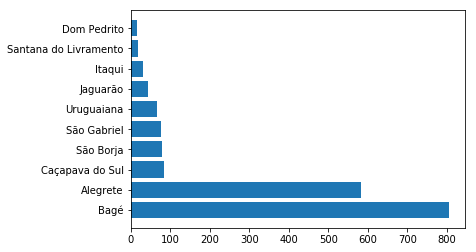

In [17]:
barh(cidades.index, cidades.values)

In [18]:
cidades.Bagé/cidades.sum()*100

44.45670159955874

In [19]:
cidades.Alegrete/cidades.sum()*100

32.156646442360724